# BERT for BETO

In [1]:
import pandas as pd
import numpy as np
import torch
import random
import os
import nltk
import time
import datetime
from nltk import tokenize
from transformers import BertTokenizer

In [5]:
#Here's what the data usually looks like: 
save_path = '/Users/Jonathan/Desktop/LabeledChemEData/Labeled_Sheets/' 
df = pd.read_excel(save_path+"Carbon_0.xlsx")

In [3]:
df

,Unnamed: 0,name,tokens,BESIO,entity,mol_class,Unnamed: 6,name.1,tokens.1,BESIO.1,...,tokens.48,BESIO.48,entity.48,mol_class.48,Unnamed: 294,name.49,tokens.49,BESIO.49,entity.49,mol_class.49
0,0,Jon O,In,NaN,NaN,NaN,0,Jon O,X-ray,NaN,...,©,NaN,NaN,NaN,0,Jon O,©,NaN,NaN,NaN
1,1,2010,the,NaN,NaN,NaN,1,2014,photoelectron,NaN,...,2020,NaN,NaN,NaN,1,2015,2015,NaN,NaN,NaN
2,2,250,interaction,NaN,NaN,NaN,2,114,spectroscopy,NaN,...,Elsevier,NaN,NaN,NaN,2,104,Elsevier,NaN,NaN,NaN
3,3,10.1016/j.carbon.2010.02.003,between,NaN,NaN,NaN,3,10.1016/j.carbon.2013.12.061,(XPS),NaN,...,Ltd,NaN,NaN,NaN,3,10.1016/j.carbon.2015.08.007,Ltd.,NaN,NaN,NaN
4,4,NaN,gas,NaN,NaN,NaN,4,NaN,has,NaN,...,The,NaN,NaN,NaN,4,NaN,Hydrogels,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,349,NaN,NaN,NaN,NaN,NaN,349,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,349,NaN,NaN,NaN,NaN,NaN
350,350,NaN,NaN,NaN,NaN,NaN,350,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,350,NaN,NaN,NaN,NaN,NaN
351,351,NaN,NaN,NaN,NaN,NaN,351,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,351,NaN,NaN,NaN,NaN,NaN
352,352,NaN,NaN,NaN,NaN,NaN,352,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,352,NaN,NaN,NaN,NaN,NaN


Need to update extract_xy_ to pull out just the x values (ie, tokens), and the y values as a smashed together BESIO. He used NLTK sent_tokenize, so we are in the same place, and we can just go back to having sentences or something.

In [2]:
def extract_xy(df):
    """
    This method extracts and correctly aranges the NER training x-values (tokens)
    and y-values (BESIO labels) from a pandas dataframe containing labeled NER
    data

    Parameters:
        df (pandas DataFrame, required): Dataframe loaded via pd.read_excel() on
            a labeled NER dataset

        endings_dict (dictionary, required): Dictionary containing the indicies
            where each sentence in each line of tokens ends.

    Returns:
        two lists of identical shape. One contains all the words that were tokenized for labeling
        and the other contains all the labels of those tokenized words.
    """
    labeled = []
    columns = df.columns
    new_df = pd.DataFrame()
    all_tokens = []
    besio = []
    mol = []
    IorO = []
        
    for idx, column in enumerate(columns):
        # find every column that starts with 'name'
        if column.startswith('name'):

            # check if the entry in 'name' cell is a str
            if isinstance(df[column][0], str):
                tokens = df[columns[idx + 1]].values
                #find the index where the tokens become NaNs, and chop the token length down to that size. 
                l = 0
                for entries in tokens: 
                    if type(entries) == str:
                        l += 1
                all_tokens.append(tokens[:l])
                df[columns[idx+2]].replace(np.nan, 'O', inplace = True)
                besio.append(df[columns[idx+2]][:l].values)
                df[columns[idx+3]].replace(np.nan, '', inplace = True)
                mol.append(df[columns[idx+3]][:l].values)
                df[columns[idx+4]].replace(np.nan, '', inplace = True)
                IorO.append(df[columns[idx+4]][:l].values)

    i = 0
    label_values = []
    while i < len(besio):
        label_values.append([])
        for j in range(len(besio[i])):
            #Strip unintentional whitespace from all entries:
            besio[i][j] = besio[i][j].replace(" ", "")
            mol[i][j] = mol[i][j].replace(" ", "")
            IorO[i][j] = IorO[i][j].replace(" ", "")
            
            if besio[i][j].upper() == 'O':
                label_values[i].append(besio[i][j].upper())
            if mol[i][j].upper() == 'PRO':
                label_values[i].append(besio[i][j].upper()+'-'+mol[i][j].upper())
            if IorO[i][j].upper() == 'I' or IorO[i][j].upper() == 'O':
                #The below does not handle cases where BESIO or MOL has errors though...
                if mol[i][j].upper() != 'PRO':
                    label_values[i].append(besio[i][j].upper()+'-'+mol[i][j].upper()+'-'+IorO[i][j].upper())
                else: 
                    print("Weird. This Property is organic or inorganic? LOL")
            #PRIME OPPORTUNITY FOR ERROR HANDLING - IF ANYTHING NOT IN THE ABOVE CATS, SOMETHING IS WRONG
            
        i += 1   
    return all_tokens, label_values

In [419]:
tokens, labels = extract_xy_(df)

ioro
ioro
PRO
PRO
ioro
ioro
ioro
PRO
ioro
PRO
PRO
PRO
ioro
ioro
ioro
PRO
PRO
ioro
PRO
ioro
ioro
PRO
PRO
ioro
PRO
ioro
ioro
ioro
ioro
ioro
PRO
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
PRO
ioro
PRO
PRO
ioro
PRO
PRO
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
PRO
ioro
ioro
ioro
ioro
ioro
ioro
ioro
PRO
ioro
ioro
PRO
PRO
PRO
PRO
ioro
ioro
ioro
PRO
PRO
PRO
PRO
ioro
ioro
PRO
PRO
ioro
ioro
ioro
PRO
PRO
ioro
PRO
ioro
ioro
ioro
ioro
PRO
ioro
ioro
ioro
ioro
ioro
PRO
ioro
ioro
ioro
ioro
ioro
PRO
PRO
ioro
ioro
ioro
ioro
ioro
ioro
ioro
PRO
ioro
ioro
PRO
PRO
ioro
ioro
PRO
PRO
PRO
PRO
ioro
PRO
ioro
ioro
ioro
ioro
ioro
ioro
PRO
PRO
PRO
PRO
PRO
PRO
ioro
ioro
PRO
PRO
PRO
PRO
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
PRO
ioro
ioro
ioro
PRO
ioro
ioro
ioro
ioro
PRO
PRO
ioro
ioro
ioro
ioro
ioro
ioro
ioro
PRO
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
ioro
PRO
PRO
PRO
PRO
PRO
PRO
PRO
PRO
ioro
ioro
ioro
PRO
PRO
ioro
ioro
ioro
ioro


In [423]:
print(labels[6])

['O', 'O', 'O', 'O', 'S-PRO', 'S-PRO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-MOL-O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-MOL-I', 'O', 'S-MOL-O', 'O', 'O', 'S-MOL-O', 'B-MOL-O', 'E-MOL-O', 'B-MOL-O', 'E-MOL-O', 'O', 'B-MOL-O', 'E-MOL-O', 'O', 'O', 'O', 'O', 'B-PRO', 'E-PRO', 'O', 'O', 'S-PRO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-MOL-I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-PRO', 'O', 'S-MOL-I', 'O', 'S-MOL-O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-PRO', 'O', 'S-PRO', 'O', 'O', 'O', 'O', 'S-MOL-O', 'S-PRO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Ok, so now we have two lists. Both lists are structured so that each entry represents a unique paper (ie, tokens[1] is a whole paper). We need to now chop it down so that all the extra entries at the end are removed, and the list tokens[1] is only as long as there are words in that paper. 

Once we have done that for each entry, we will need to build a looping/wrapper function that will read every excel sheet in a directory. It'd be ideal if that looping function would append each new list to the previous list, so we could end up with every single labeled paper in a single set of two lists. 

After we have that function built, the next step is to try to regenerate our sentence-split structure. First step is to make each paper back into a single string. We'll do this by making a homemade inverse .split() function, which means we'll add each item in the tokens[1] list together with a single whitespace between them. Example is in the case ['The', 'dog', 'ran.'] we would want to regen the original string of ['The dog ran.']. We could do that by doing original_string += (token[1][i]+ ' '). Once we have made each paper in the list back into individual strings, we'll chop each string into individual sentences by using NLTK. 

All of the above is now done!

From that point, it's more standard BERT. We'll use BERT's tokenizer. We'll need to make sure we hand-extend each label to match the tokenization done by the BERT tokenizer so we don't have length mismatches (a la: https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/ function tokenize_and_preserve_labels) and then we'll send it to a dataloader. 

In [3]:
#Ok, need another def function that takes in a list of tokens, and a list of labels, and returns them each as a list of strings
def tokenized_to_string(token_list):
    token_stringlist = []
    for paper_tokens in token_list:
        paper_string = ""
        for i in paper_tokens:
            #This is basically an 'unsplit' method lol
            paper_string += (str(i) + " ")
        token_stringlist.append(paper_string)
    return token_stringlist

In [4]:
def labeled_sheets_to_listed_tokens(directory_url):
    """This function opens a directory of labeled excel sheets from David's excel sheets and returns the tokens as a list 
    of strings fully combined on a document level. It returns a list of strings, with each string being a full document."""
    files = os.listdir(directory_url)
    token_list = []
    label_list = []
    sent_labels = []
    for file in files:
        df = pd.read_excel(directory_url+file)
        token, label = extract_xy(df)
        token_list += (tokenized_to_string(token))
        label_list += (label)
    #Now we tokenize each paper by sentences using NLTK:
    #we will also restructure labels to be ordered by sentences. 
    for i in range(len(token_list)):
        sentences = tokenize.sent_tokenize(token_list[i])
        token_list[i] = sentences
        short_term_labels = []
        for j in range(len(token_list[i])):    
            length = len(token_list[i][j].split())
            short_list = label_list[i][:length]
            short_term_labels.append(short_list)
            del(label_list[i][:length])
        sent_labels.append(short_term_labels)
    return token_list, sent_labels

In [5]:
dir_url = '/Users/Jonathan/Desktop/LabeledChemEData/Labeled_Sheets/'
list_o_tokens, list_o_labels = labeled_sheets_to_listed_tokens(dir_url)

Weird. This Property is organic or inorganic? LOL
Weird. This Property is organic or inorganic? LOL


In [472]:
print(list_o_tokens[5])
print(list_o_labels[5])

['In this work we study the carbonization resulting from an intumescence phenomenon of the fire-retardant formulation: ethylene terpolymer-ammonium polyphosphate/pentaerythritol.', 'Characterisation of the intumescent coating is carried out using infrared spectroscopy and MAS-NMR of the solid state.', 'The study shows the formation of organic phosphocarbonaceous esters, which limits depolymerisation or the evolution of gaseous hydrocarbons.', 'These esters prevent the development of condensed polyaromatic structures.', 'These latter are bridged by the polyethylenic links, which provide the mechanical properties of interest in the protective shield.', '©']
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-PRO', 'O', 'B-MOL-O', 'I-MOL-O', 'E-MOL-O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOL-O', 'E-MOL-O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O',

Ok, now that we've got our fully organized token and label lists, we need to set some max length limits for our sentences, as all sentences input into BERT have to have the same length. That being said, we need to be sure that our length is based off of the length from the BERT tokenizer, not just the number of words in a sentence. To do that, we'll set up our tokenizer, and then use it to figure out the longest encoded length in our corpus. 

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [7]:
def drop_empty_sentences(token_list, label_list, label_dict):
    """This function is a form of undersampling an overshadowing case, 
    as it is dropping all examples of sentences where only O labels exist."""
    labels_list = list(label_dict.keys())
    flip = 0
    list_of_deletions = []
    del_counter = 0
    for i in range(len(labels_list)):
        if labels_list[i] == 'O':
            del(labels_list[i])
            flip = 1
        if flip == 1:
            break
    for i in range(len(token_list)):
        for j in range(len(token_list[i])):
            if any(x in label_list[i][j] for x in labels_list):
                pass
            else:
                list_of_deletions.append([i,j])
    print(list_of_deletions)
    while len(list_of_deletions) != 0:
        i,j = list_of_deletions[-1]
        del(label_list[i][j])
        del(token_list[i][j])
        del(list_of_deletions[-1])
        del_counter += 1
    print("Total deleted sentences = " + str(del_counter))
    return token_list, label_list

As a form of subsampling, let's plan to drop all full-sentences that don't have any labels besides "O" in them. We'll need to define a dictionary with keys to all the labels we've put into our corpus first though.

In [8]:
#Long term we should absolutely consider getting rid of S, E labels
#For now, let's change O to not be the same as PAD, and see if that helps.
small_label_mapping = {'O': 3, "B-MOL-O": 1, "I-MOL-O": 1, "E-MOL-O": 1,
                "S-MOL-O": 1, "B-MOL-I": 1, "I-MOL-I": 1, "E-MOL-I": 1,
                "S-MOL-I": 1, "B-PRO": 2, "I-PRO": 2, "E-PRO": 2, "S-PRO": 2,
                'PAD': 0}


In [13]:
drop_empty_sentences(list_o_tokens, list_o_labels, small_label_mapping)

[[0, 1], [0, 3], [1, 7], [2, 4], [5, 1], [5, 5], [7, 4], [7, 6], [8, 1], [8, 3], [9, 1], [9, 6], [13, 2], [13, 3], [13, 6], [13, 7], [14, 1], [14, 9], [15, 6], [16, 2], [16, 4], [17, 4], [17, 8], [19, 2], [19, 4], [19, 6], [20, 3], [20, 4], [21, 2], [23, 5], [24, 7], [25, 4], [26, 5], [27, 5], [28, 0], [30, 5], [32, 6], [33, 2], [33, 3], [33, 4], [33, 6], [34, 5], [35, 7], [36, 3], [36, 10], [36, 11], [37, 2], [37, 6], [38, 5], [39, 1], [40, 1], [40, 4], [40, 5], [40, 6], [40, 8], [41, 1], [41, 5], [41, 6], [41, 7], [41, 8], [41, 9], [41, 10], [41, 13], [41, 14], [41, 22], [42, 1], [42, 4], [42, 6], [43, 1], [43, 2], [43, 6], [45, 4], [46, 2], [47, 8], [49, 4], [49, 5], [50, 7], [51, 0], [53, 1], [53, 2], [53, 3], [53, 4], [53, 6], [54, 0], [55, 3], [55, 4], [55, 5], [57, 1], [57, 7], [59, 0], [59, 1], [59, 2], [59, 4], [59, 6], [59, 9], [60, 1], [60, 4], [61, 6], [61, 8], [62, 7], [62, 8], [63, 1], [63, 5], [63, 7], [64, 8], [65, 4], [65, 5], [65, 7], [66, 0], [66, 5], [67, 0], [67, 1

([['In the interaction between gas molecules with single-walled carbon nanotube (SWCNT) we show that as a result of collisions the gas scattering contributes with an important background signal and should be considered in SWCNT-based gas sensors.',
   'Results support the occurrence of the scattering process and show how gas collisions may affect the electronic structure of SWCNTs.'],
  ['X-ray photoelectron spectroscopy (XPS) has been commonly used to determine the nitrogen-containing functional groups of graphene.',
   'However, reported assignments of C1s shifts of nitrogen-containing functional groups are unclear.',
   'Most works discuss peak shifts of only N1s spectra and C1s shifts and the full width at half maximum (FWHM) are excluded.',
   'Thus, peak shifts and FWHMs of C1s and N1s XPS spectra of graphene with nitrogen-containing functional groups such as pyridinic, phenanthroline-like, sp2C-NH2, sp 3C-NH2, pyrrolic, imine, pyridazine-like, pyrazole-like, sp2C-CN, sp3C-CN, an

In [14]:
print(list_o_labels[2][4])

IndexError: list index out of range

In [9]:
def max_encoded_length(token_list):
    max_len = 0
    len_list = []
    for papers in token_list:
        for sentences in papers:
            input_ids = tokenizer.encode(sentences, add_special_characters = True)
            max_len = max(max_len, len(input_ids))
            len_list.append(len(input_ids))
            
    return max_len, len_list

In [18]:
max_, length_list = max_encoded_length(list_o_tokens)

In [19]:
import matplotlib.pyplot as plt

(array([ 67., 135., 152., 227., 174., 149., 117.,  62.,  52.,  34.,  33.,
         15.,  15.,   9.,  11.,   3.,   3.,   5.,   3.,   6.]),
 array([  3. ,  10.3,  17.6,  24.9,  32.2,  39.5,  46.8,  54.1,  61.4,
         68.7,  76. ,  83.3,  90.6,  97.9, 105.2, 112.5, 119.8, 127.1,
        134.4, 141.7, 149. ]),
 <a list of 20 Patch objects>)

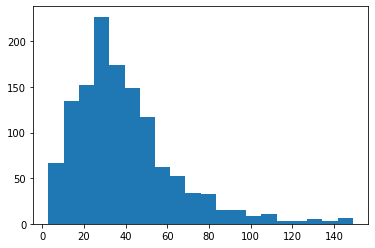

In [20]:
#Quick plot to show approx dist of sentence lengths in our corpus
fig, axs = plt.subplots()
axs.hist(length_list, 20)

Ok, so the longer the dataset input, the worse performance is going to get. It turns out the performance of BERT scales quadratically with feature size. Esp. when we only have like 17 sentences greater than 150 words, it seems insane to use so much extra dimensionality. Instead, what we'll do is we'll chunk up sentences to a specific length. BUT, in order to get context, we need to have overlap of each chunked sequence, though it's not clear exactly how much overlap we will need, as this is kinda non-standard. My thought is if we limit max input length to 150, we could then chunk stuff up into 150-length inputs, wherein there are like 25 input overlaps on either side of the sentence.  

Alternatively, we could just delete any sentences that are greater than a certain size. To begin with, we will just delete sentences.

RIght now, I want to make a function that will truncate all sentences and labels to just a certain size. In this case, we'll truncate to 70 words, based on the above plot showing most sentences will be unaffected. The goal here is to remove as many padding tokens as possible, to see if that help improve our overall model performance.

In [ ]:
list_of_labels, list_o_tokens

In [ ]:
def truncate_sentences(token_list, label_list, sentence_length = 65):
    """This function truncates sentences to a set size."""
    

If we chop all sentences with greater than 150 words, we lose 1.4% of our sentences.
If we chop all sentences with greater than 160 words, 
we lose 1.24%
If we chop all with greater that 175, we lose 0.78%
If we chop with greater than 200, we lose 0.38% (5 sentences)


We'll use 150 at first, because we want to try to train locally if at all possible.

In [13]:
def delete_sentences(token_list, label_list, print_pop = False, max_length = 150):
    i = 0
    #lets use pop to remove these long sentences
    while i < len(token_list):
        list_of_j = []
        j = 0
        while j < len(token_list[i]):
            input_ids = tokenizer.encode(token_list[i][j], add_special_tokens = True)
            if len(input_ids) > 150:
                print("Found item length: " + str(len(input_ids)))
                list_of_j.append(j)
            j += 1
        k = len(list_of_j)-1
        #Gotta count backwards so we don't disturb the list structure
        while k > -1:
            if print_pop:
                print(token_list[i].pop(list_of_j[k]))
                print(label_list[i].pop(list_of_j[k]))
            else:
                token_list[i].pop(list_of_j[k])
                label_list[i].pop(list_of_j[k])
            k = k - 1
        i += 1 
    return token_list, label_list

In [14]:
short_sent_list, short_label_list = delete_sentences(list_o_tokens, list_o_labels)

Found item length: 181
Found item length: 189
Found item length: 172
Found item length: 270
Found item length: 178
Found item length: 191
Found item length: 171
Found item length: 151
Found item length: 235
Found item length: 161
Found item length: 509
Found item length: 174
Found item length: 207
Found item length: 248
Found item length: 180
Found item length: 155
Found item length: 165
Found item length: 173


In [206]:
max_encoded_length(short_sent_list)[0]

149

Because of this, we'll set our maximum length inside of BERT to be 155, just to be safe. It's probably a bit unnecessary, but for our relatively small dataset, I bet the extra 6D won't be a crisis.

Here's what I just learned: We can use the tensordataset loader things. We need to change our label list though. The label needs to have an O token for the CLS and SEP tokens, and that O token should also exist for the padding values. We also DO need to increase the length of each individual word label across the tokenized expansion of the word. 

Finally, once we've done all that, we need to convert the whole label list into individual integer mappings. We should build a label to number mapper, and then a number to label mapper at the same time. Should mostly just be a dictionary and key mapper type thing. 

In [ ]:
#Maybe we'll get back to this someday
# label_mapping = {'O': 13, "B-MOL-O": 1, "I-MOL-O": 2, "E-MOL-O": 3,
#                 "S-MOL-O": 4, "B-MOL-I": 5, "I-MOL-I": 6, "E-MOL-I": 7,
#                 "S-MOL-I": 8, "B-PRO": 9, "I-PRO": 10, "E-PRO": 11, "S-PRO": 12,
#                 'PAD': 0}

In [94]:
label_mapping = {'PAD': 0, 'MOL': 1, 'PRO': 2, 'O': 3}

In [207]:
input_ids = []
attention_masks = []
label_shapes = []
no_pad_labels = []
count = 0

for abstracts, abst_labels in zip(short_sent_list, short_label_list):
    for sentences, sent_labels in zip(abstracts, abst_labels):
        encoded_dict = tokenizer.encode_plus(
                                    sentences,
                                    add_special_tokens = True,
                                    max_length = 155,
                                    pad_to_max_length = True,
                                    return_attention_mask = True,
                                    return_tensors = 'pt'
        )
        #Ok, now we get our labels based on encoded sizes. 
        #Make this a standalone function later instead of nesting
        #Need to start the CLS token to every label. 
        #This CLS token should be a int 0, to keep label
        #length matching consistent with the tokenized sentence
        extend_sent_labels = [0]
        
        
        #I Bet the problem with things being read in is the difference in length of 
        #however this chunks sentences versus how the labels were originally split.
        
        for word, label in zip(sentences, sent_labels):
            tokenized_word = tokenizer.tokenize(word)
            #Find out how many chunks each word gets broken into
            n_subwords = len(tokenized_word)
            #Extend the length of the labels to match new word length
            #Put label in brackets so it knows you want n_subwords entries
            #of label, not label times n_subwords
            extend_sent_labels.extend([label]*n_subwords)
        
        #In order to know just how much to bias the dataset for each label, we need to know how many of each we have. 
        no_pad_labels.extend(extend_sent_labels)
        
        #This handles increasing the length for padding and sep tokens
        #Go all the way to 155. Padding and  SEP should both be PAD tokens in label form
        #Because the key map will switch them to a 0. 
        extend_sent_labels.extend(['PAD']*(155-len(extend_sent_labels)))    
#
        #Next step, we need to use the dictionary lookup
        #to replace all the values from this list to become 
        #numbers. for loops to go through the whole list. 
        for i in range(len(extend_sent_labels)):
            if extend_sent_labels[i] in small_label_mapping.keys():
                #Replace the label in extend_set_labels[i] from dict
                extend_sent_labels[i] = small_label_mapping[extend_sent_labels[i]]
        #print(extend_sent_labels)
        #Then, we make the labels list into a tensor.
        #extend_sent_labels = torch.tensor(extend_sent_labels)
        test_list = []
        test_list.append(extend_sent_labels)
        test_list = torch.tensor(test_list)
        #Build our attention mask, labels, and input ids of each item.
        label_shapes.append(test_list)
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

print(len(label_shapes[1]))
print(len(input_ids[1]))
print(len(attention_masks[1]))

#Make lists we just built into tensors
input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.cat(label_shapes, dim = 0)

print("Original Sentence: ", short_sent_list[0][0])
print("Tokenized IDs: ", input_ids[0])
print(labels[0])

1
1
1
Original Sentence:  In the interaction between gas molecules with single-walled carbon nanotube (SWCNT) we show that as a result of collisions the gas scattering contributes with an important background signal and should be considered in SWCNT-based gas sensors.
Tokenized IDs:  tensor([  101,  1999,  1996,  8290,  2090,  3806, 10737,  2007,  2309,  1011,
        17692,  6351, 28991, 28251,  2063,  1006, 25430,  2278,  3372,  1007,
         2057,  2265,  2008,  2004,  1037,  2765,  1997, 28820,  1996,  3806,
        17501, 16605,  2007,  2019,  2590,  4281,  4742,  1998,  2323,  2022,
         2641,  1999, 25430,  2278,  3372,  1011,  2241,  3806, 13907,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0

In [209]:
#OK, now that we have a list of all labels, we need to convert them to their number forms
#From the number forms, we'll then build the relative weight for each of these entries. 

#THIS SHOULD BE A FUNCTION SINCE I CALL IT TWICE:
for i in range(len(no_pad_labels)):
    if no_pad_labels[i] in small_label_mapping.keys():
        #Replace the label in extend_set_labels[i] from dict
        no_pad_labels[i] = small_label_mapping[no_pad_labels[i]]

In [210]:
len(no_pad_labels)

20951

In [99]:
1272*155

197160

In [100]:
24622/197160

0.12488334347737878

In [211]:
#Now, we take the number converted label, and use it to build a list. 
#Initialize a list of zeros to count every instance of each key:
key_count_list = np.zeros(len(label_mapping.keys()))
for i in range(len(no_pad_labels)):
    key_count_list[no_pad_labels[i]] += 1

In [212]:
#Note that we see 1272 of the PAD tokens - this is because the CLS start token is getting counted.
#We shouldn't really use this value for anything, but we'll note it here. 
print(key_count_list)

[  966.  2904.   987. 16094.]


In [105]:
sum(key_count_list)

24622.0

In [213]:
#Ok, we can calculate relative weights for each output by: 
list_o_weights = (sum(key_count_list)/(len(label_mapping.keys())*key_count_list))

In [214]:
list_o_weights

array([5.42210145, 1.80363292, 5.30673759, 0.32544737])

In [215]:
#Note that the weight for the padding token is much bigger than the outside - let's set PAD based off 80% of outside 
#Since we know that there are more padding tokens than outside, for sure.
list_o_weights[0] = 0.8*list_o_weights[3]
print(list_o_weights)

[0.2603579  1.80363292 5.30673759 0.32544737]


In [216]:
#Real quick percentage functions for each.
perc_list = []
for i in range(len(key_count_list)):
    perc_list.append(key_count_list[i]/sum(key_count_list))

In [217]:
print(perc_list)

[0.04610758436351487, 0.13860913560211924, 0.04710992315402606, 0.7681733568803398]


In [218]:
bias_list = np.log(key_count_list/sum(key_count_list))

In [219]:
#This is a list of all biases for each output class.
#If you check, these values through softmax equation give percentages from perc list
bias_list

array([-3.07677782, -1.97609728, -3.05527162, -0.26373985])

In [220]:
#As with the weight list, we should adjust the biases for the PAD tags to be some percentage of the outside tag
bias_list[0] = 0.8*bias_list[3]
print(bias_list)

[-0.21099188 -1.97609728 -3.05527162 -0.26373985]


Ok. Now we have a label list, an attention mask, and an input id that are all the same shape, and contain all the data, in full integer form, so everything can be put into a DataLoader, and then we can start thinking about putting everything into the BERT model. Very exciting! Let's start with a dataloader.

In [222]:
from torch.utils.data import TensorDataset, random_split

In [223]:
dataset = TensorDataset(input_ids, attention_masks, labels)

#Do our 90/10 training/validation split
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

#Now do a train_val split, randomly
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  869 training samples
   97 validation samples


In [224]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [225]:
#Set a dataloader batch size. Paper says do 16 or 32, but do bigger if comp can
batch_size = 32

#Create training dataloaders using a random sequence pull
train_dataloader = DataLoader(train_dataset,
                             sampler = RandomSampler(train_dataset),
                             batch_size = batch_size
                             )

#Validation can go any order, so we'll do sequentially
validation_dataloader = DataLoader(val_dataset,
                                  sampler = SequentialSampler(val_dataset),
                                  batch_size = batch_size
                                  )


In [226]:
from transformers import BertForTokenClassification, AdamW, BertConfig

In [256]:
model = BertForTokenClassification.from_pretrained(
        "bert-base-uncased",
        num_labels = len(label_mapping.keys()),
        output_attentions = False, #Whether model returns attention weights
        output_hidden_states = False, #Whether model outputs all hidden states
)    

In [228]:
#Gotta multiply the classifier weight by our calculated weight values for each vector weight. 
#list_o_weights is my previously calculated weight list set.
#I have no idea if position 0 in classifier.weight is weight for classification 0. I bet it is, but should check.
#Make our new blank canvas tensor
temp_tensor = torch.empty((len(label_mapping.keys()),768), requires_grad = True)
#Initialize our tensor with standard xavier_normal equation
torch.nn.init.xavier_normal_(temp_tensor)
print(temp_tensor)
#Turn off grad calcs so we don't track our weight changes.
#Then, we want to multiply the absolute weights from xavier init by our weight list calced earlier to get our
#final model weight values
with torch.no_grad():
    for i in range(len(temp_tensor)):
        temp_tensor[i] = (temp_tensor[i] * list_o_weights[i])     
#Check that the tensor got updated correctly
print(temp_tensor)
#Update the classifier weight with the new tensor
model.classifier.weight = torch.nn.Parameter(temp_tensor, requires_grad = True)
#Make sure it got updated correctly
print(model.classifier.weight)

tensor([[ 0.0122, -0.0353, -0.0646,  ..., -0.0203,  0.0410, -0.0155],
        [-0.0107, -0.0320,  0.0139,  ...,  0.0340,  0.0794,  0.0388],
        [ 0.1179,  0.0060, -0.0252,  ..., -0.1218,  0.0899, -0.0074],
        [-0.0194, -0.0233,  0.0101,  ..., -0.0202,  0.0419,  0.1112]],
       requires_grad=True)
tensor([[ 0.0032, -0.0092, -0.0168,  ..., -0.0053,  0.0107, -0.0040],
        [-0.0192, -0.0578,  0.0251,  ...,  0.0613,  0.1432,  0.0700],
        [ 0.6256,  0.0320, -0.1337,  ..., -0.6464,  0.4769, -0.0393],
        [-0.0063, -0.0076,  0.0033,  ..., -0.0066,  0.0136,  0.0362]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0032, -0.0092, -0.0168,  ..., -0.0053,  0.0107, -0.0040],
        [-0.0192, -0.0578,  0.0251,  ...,  0.0613,  0.1432,  0.0700],
        [ 0.6256,  0.0320, -0.1337,  ..., -0.6464,  0.4769, -0.0393],
        [-0.0063, -0.0076,  0.0033,  ..., -0.0066,  0.0136,  0.0362]],
       requires_grad=True)


In [231]:
#check current bias status
model.classifier.bias

Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)

In [232]:
#OK, I need to make a torch.nn.Parameter out of my bias list, and then I can pass it to the classifier. 
#Some details: Since the default requires_grad for model is true, we'll keep that. 
bias_tensor = torch.tensor(bias_list)
new_classifier_bias = torch.nn.Parameter(bias_tensor, requires_grad = True)
#Now, we update the classifier bias
model.classifier.bias = new_classifier_bias
#And make sure it's been updated
print(model.classifier.bias)

Parameter containing:
tensor([-0.2110, -1.9761, -3.0553, -0.2637], dtype=torch.float64,
       requires_grad=True)


In [122]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

The BERT model has 201 different named parameters.



In [48]:
print(params[-1][0])

classifier.bias


In [49]:
print(params[-1][1])

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)


In [41]:
print(params[-2])

('classifier.weight', Parameter containing:
tensor([[ 0.0417,  0.0022,  0.0198,  ..., -0.0140, -0.0161, -0.0122],
        [ 0.0173, -0.0088, -0.0033,  ..., -0.0014,  0.0194,  0.0048],
        [-0.0078, -0.0309,  0.0159,  ..., -0.0197,  0.0299, -0.0307],
        ...,
        [ 0.0154, -0.0061, -0.0070,  ...,  0.0343,  0.0054,  0.0221],
        [-0.0200, -0.0007,  0.0093,  ...,  0.0205,  0.0308,  0.0139],
        [ 0.0131, -0.0187,  0.0436,  ...,  0.0221,  0.0187, -0.0014]],
       requires_grad=True))


In [174]:
#Print the parameters related to the final layer. There's a pooling section, then a classifier section. 
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

bert.pooler.dense.weight                                  (768, 768)
bert.pooler.dense.bias                                        (768,)
classifier.weight                                          (13, 768)
classifier.bias                                                (13,)


In [257]:
#Need to run this on the cpu for right now :(
#Double check that this doesn't raise an error - it's usually warning about tensors not having grads correct
model.cpu()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

For the purposes of fine-tuning, the authors (ie Google AI) recommend choosing from the following values (from Appendix A.3 of the BERT paper):

Batch size: 16, 32 Learning rate (Adam): 5e-5, 3e-5, 2e-5 Number of epochs: 2, 3, 4 We chose:

Batch size: 32 (set when creating our DataLoaders) Learning rate: 2e-5 Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter eps = 1e-8 is "a very small number to prevent any division by zero in the implementation

In [234]:
from transformers import get_linear_schedule_with_warmup

In [128]:
def model_initialization(epochs, training_dataloader, validation_dataloader, learning_rate, model, label_dictionary, bias = True, weights = True):
    """If bias or weights is true, it will calc initial biases and weights for model based on class imbalance."""    

In [129]:
def opt_sched_initialize(total_steps, learning_rate, model, epsilon = 1e-8, warmup_steps = 0):
    """Initialize the model's optimizer (Adam with weight decay) and scheduler(linear schedule with warmup)"""
    #Default lr = 2e-5
    optimizer = AdamW(model.parameters(),
                     lr = learning_rate,
                     eps = epsilon
                     )
    # Total number of training steps is [number of batches] x [number of epochs]. 
    # (Note that this is not the same as the number of training samples).
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                               num_warmup_steps = warmup_steps,
                                               num_training_steps = total_steps)
    return optimizer, scheduler

In [258]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [259]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 1. Largely cause I'm not sure my computer will survive
#This could also be a major source of error. I'm thinking I'll try 2 next and pray.
#When I ran for 20 epochs, the model saturated around 5 epochs with 2e-5 lr though.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [260]:
#Long term, need to update this to not bother with incorrect. 
#THIS IS STILL NOT RIGHT>

def my_flat_accuracy(preds, labels, atten_mask):
    """All inputs better have the same shape or you're going to have a bad time. They ought to be if you're doing it all right though."""
    #First we gotta get the predicted values out and put them into a 2D array. argmax ought to do it, but
    #We can see that it didn't work for me earlier (ie, I probs don't understand it) We'll hack an answer.
    #Make array with shape equal to the input sentences and the word by word breakdown of the sentences
    #First step is to find all of the assigned labels.
    #Can only get away with setting shape of len(preds[0]) bc we know BERT has to have all sentences the same length
    pred_winner = np.zeros(shape = (len(preds), len(preds[0])))
    total = 0
    correct = 0
    incorrect = 0
    for i in range(len(preds)):
        for j in range(len(preds[i])):
            pred_winner[i][j] = np.where(preds[i][j] == max(preds[i][j]))[0][0]
    #Once we have our classification for every word in every sentence, then it's time to do the accuracy math
    #This is where we need to consider the attention masking, removing any PAD, CLS, and SEP tokens. 
    for i in range(len(pred_winner)):
        for j in range(len(pred_winner[i])):
            #This is skipping the CLS token.
            if j == 0:
                pass
            else:
                #This condition represents the absolute position of the sep token
                if atten_mask[i][j] + atten_mask[i][j+1] == 1:
                    #We don't want to increment the total counter, and there's no point
                    #going through the rest of the j-values, they're all PADs
                    #As such, we use break to bounce out of the j for loop. 
                    #print("End of sentence")
                    break
                #This is the condition for when that token is a real sentence token (not PAD)
                if atten_mask[i][j] + atten_mask[i][j+1] == 2:
                    #This as a real token, so it adds to total
                    total += 1
                    #Check if the label matches prediction, if so, increment the correct counter
                    if pred_winner[i][j] == labels[i][j]:
                        correct += 1
                    else:
                        incorrect += 1
    return correct, total

In [238]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [239]:
def logits_to_predictions(preds):
    """This function takes in a list of logits (which are 3D in nature) and returns a list of predictions (2D in shape)"""
    #Make array with shape equal to the input sentences and the word by word breakdown of the sentences
    #First step is to find all of the assigned labels.
    #Can only get away with setting shape of len(preds[0]) bc we know BERT has to have all sentences the same length
    predictions = np.zeros(shape = (len(preds), len(preds[0])))
    for i in range(len(preds)):
        for j in range(len(preds[i])):
            predictions[i][j] = np.where(preds[i][j] == max(preds[i][j]))[0][0]
    return predictions

In [261]:
model.float()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [262]:
device = torch.device("cpu")

I really do need to put together a simpler example. Maybe typecast all labels to just be binary. 1 if we care about it, 0 if we don't. That'd deal with the BESIO issue, and makes it so we need less training examples. We could then blink to 3 tags, 0 for outside, 1 for mol compounds, and 2 for properties. Then we can eventually get this whole thing here. 

In [243]:
import pandas as pd

In [90]:
conf_mat_df = pd.DataFrame()
linear = np.linspace(0, 13, num = 14, dtype = int)
index = ("Pred: " + str(i) for i in linear)
for i in range(len(conf_mat)):
    conf_mat_df['Act_labels: ' + str(i)] = conf_mat[i]
conf_mat_df.set_index(index)

,Act_labels: 0,Act_labels: 1,Act_labels: 2,Act_labels: 3,Act_labels: 4,Act_labels: 5,Act_labels: 6,Act_labels: 7,Act_labels: 8,Act_labels: 9,Act_labels: 10,Act_labels: 11,Act_labels: 12,Act_labels: 13
Pred: 0,17371.0,27.0,9.0,25.0,119.0,18.0,5.0,23.0,79.0,24.0,9.0,23.0,44.0,2064.0
Pred: 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pred: 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pred: 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pred: 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pred: 5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pred: 6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pred: 7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pred: 8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pred: 9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
conf_mat_df

,Act_labels: 0,Act_labels: 1,Act_labels: 2,Act_labels: 3,Act_labels: 4,Act_labels: 5,Act_labels: 6,Act_labels: 7,Act_labels: 8,Act_labels: 9,Act_labels: 10,Act_labels: 11,Act_labels: 12,Act_labels: 13
0,17371.0,27.0,9.0,25.0,119.0,18.0,5.0,23.0,79.0,24.0,9.0,23.0,44.0,2064.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [263]:
def prettify_confusion_matrix(confusion_matrix):
    conf_mat_df = pd.DataFrame()
    linear = np.linspace(0, len(confusion_matrix)-1, num = len(confusion_matrix), dtype = int)
    index = ("Pred: " + str(i) for i in linear)
    for i in range(len(confusion_matrix)):
        conf_mat_df['Act_labels: ' + str(i)] = confusion_matrix[i]
    conf_mat_df.set_index(index)
    return conf_mat_df

In [264]:
def calc_confusion_matrix(confusion_matrix, guesses, actual_labels):
    #Guesses has already been normalized to the maximum probability for each token
    for i in range(len(guesses)):
        for j in range(len(guesses[i])):
            confusion_matrix[int(actual_labels[i][j])][int(guesses[i][j])] += 1
    return confusion_matrix

In [265]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []
#Gotta get these to build a confusion matrix.
predictions, true_labels = [], []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    #Reset the confusion matrix for this epoch
    #Note that conf mat shape has axis 0 being actual label, axis 1 being guessed label
    conf_mat = np.zeros(shape = (14,14))

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 3 batches.
        if step % 3 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU - Do we need?
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #Need to keep track of predictions and true labels for conf matrix
        #First, we need to modify logits. IDK Why
        #I think we need to do it on 2. Logits structure goes in 3D. D1 is the list of all the sentences
        #D2 is the list of every token within each sentence. D3 is the label predicted values.
        #Need to get the maximum values from the D3 to figure out each of the actual predictions here. 
#         for i in range(len(logits)):
#             pred_list = []
#             for j in range(len(logits[i])):
#                 #Gotta modify this somehow still
#                 #pred_winner[i][j] = preds[i][j].index(max(preds[i][j]))

        current_guesses = logits_to_predictions(logits)

        #Let's get a way to keep track of all the predictions and correct labels
        predictions.extend(current_guesses)
        true_labels.extend(label_ids)        

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        num_correct, total_num = my_flat_accuracy(logits, label_ids, b_input_mask)
        #This probably looks wrong - But we divide later by len(dataloader) to drop it 
        #back down to a true 100% maximum, don't worry!
        total_eval_accuracy += (num_correct/total_num)

        #Now we add our most recent guesses to our confusion matrix:
        conf_mat = calc_confusion_matrix(conf_mat, current_guesses, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    #Print the confusion matrix for this training epoch:
    nice_conf_mat = prettify_confusion_matrix(conf_mat)
    print(nice_conf_mat)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time,
            'Confusion Matrix': nice_conf_mat
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 5 ========
Training...
  Batch     3  of     28.    Elapsed: 0:01:25.
  Batch     6  of     28.    Elapsed: 0:02:33.
  Batch     9  of     28.    Elapsed: 0:04:20.
  Batch    12  of     28.    Elapsed: 0:06:05.
  Batch    15  of     28.    Elapsed: 0:07:49.
  Batch    18  of     28.    Elapsed: 0:09:33.
  Batch    21  of     28.    Elapsed: 0:11:16.
  Batch    24  of     28.    Elapsed: 0:13:00.
  Batch    27  of     28.    Elapsed: 0:14:37.

  Average training loss: 0.80
  Training epcoh took: 0:14:44

Running Validation...
  Accuracy: 0.84
    Act_labels: 0  Act_labels: 1  Act_labels: 2  Act_labels: 3  Act_labels: 4  \
0         10548.0            7.0            3.0           69.0            0.0   
1             0.0            0.0            0.0            0.0            0.0   
2             0.0            0.0            0.0            0.0            0.0   
3          2462.0          260.0           99.0         1587.0            0.0   
4             0.0          

In [72]:
def train_and_validate(epochs, model, train_dataloader, valid_dataloader, optimizer, scheduler):
    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    
    device = torch.device('cpu')

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []
    #Gotta get these to build a confusion matrix.
    predictions, true_labels = [], []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        #Reset the confusion matrix for this epoch
        #Note that conf mat shape has axis 0 being actual label, axis 1 being guessed label
        conf_mat = np.zeros(shape = (14,14))

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 3 batches.
            if step % 3 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            loss, logits = model(b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                (loss, logits) = model(b_input_ids, 
                                       token_type_ids=None, 
                                       attention_mask=b_input_mask,
                                       labels=b_labels)

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU - Do we need?
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            #Need to keep track of predictions and true labels for conf matrix
            #First, we need to modify logits. IDK Why
            #I think we need to do it on 2. Logits structure goes in 3D. D1 is the list of all the sentences
            #D2 is the list of every token within each sentence. D3 is the label predicted values.
            #Need to get the maximum values from the D3 to figure out each of the actual predictions here. 
    #         for i in range(len(logits)):
    #             pred_list = []
    #             for j in range(len(logits[i])):
    #                 #Gotta modify this somehow still
    #                 #pred_winner[i][j] = preds[i][j].index(max(preds[i][j]))

            current_guesses = logits_to_predictions(logits)

            #Let's get a way to keep track of all the predictions and correct labels
            predictions.extend(current_guesses)
            true_labels.extend(label_ids)        

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            num_correct, total_num = my_flat_accuracy(logits, label_ids, b_input_mask)
            #This probably looks wrong - But we divide later by len(dataloader) to drop it 
            #back down to a true 100% maximum, don't worry!
            total_eval_accuracy += (num_correct/total_num)

            #Now we add our most recent guesses to our confusion matrix:
            conf_mat = calc_confusion_matrix(conf_mat, current_guesses, label_ids)


        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        #Print the confusion matrix for this training epoch:
        print(conf_mat)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time,
                'Confusion Matrix': conf_mat
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    
    return training_stats, predictions, true_labels

Next step after this is to obviously tune the model for our specific stuff, if this results is weird or whatever.
We'll need to do a hyperparameter optimization step.
We'll need to do a train and test split, instead of just a validation split. 
We'll need to find a way to save the model's final state. 
We need a way to use our model to predict the label for input documents. Right now, Idk how that would work. We should build it for a single sentence at a time. 

Ok, I need to explore the format of the attention masks, to make sure it's working correctly, and also to build the right functionality for my accuracy function, such that it doesn't calculate accuracy based upon the PAD tokens, or the CLS or SEP tokens. I know that it labels the CLS and SEP tokens with a 1, but I know where they are in the sentence, so that shouldn't be hard to if statement my way around. But we do need to get the PAD tokens from the attention mask input. 

In [52]:
training_stats[19]

{'epoch': 20,
 'Training Loss': 0.31108416120211285,
 'Valid. Loss': 0.5176265314221382,
 'Valid. Accur.': 0.8880074523330863,
 'Training Time': '0:12:22',
 'Validation Time': '0:00:32',
 'Confusion Matrix': array([[1.6242e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 0.0000e+00, 1.2780e+03],
        [2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00],
        [2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 2.2000e+01],
        [

In [267]:
training_list = []
valid_loss = []
valid_accuracy = []
for i in range(len(training_stats)):
    training_list.append(training_stats[i]['Training Loss'])
    valid_loss.append(training_stats[i]['Valid. Loss'])
    valid_accuracy.append(training_stats[i]['Valid. Accur.'])

Text(0.5, 1.0, 'No Weights and Biases')

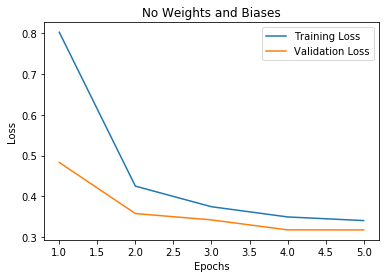

In [272]:
x = [1,2,3,4,5]
plt.plot(x, training_list, label = "Training Loss")
plt.plot(x, valid_loss, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("No Weights and Biases")

Text(0.5, 1.0, 'No Weights and Biases')

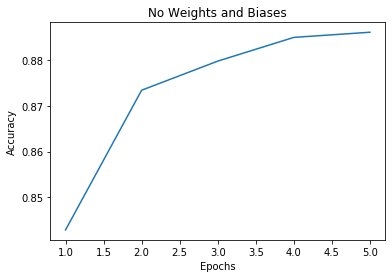

In [273]:
x = [1,2,3,4,5]
plt.plot(x, valid_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("No Weights and Biases")

In [270]:
#Now save conf mat:
import pickle
with open('/Users/Jonathan/Desktop/5epochnoweightbias2e-5learningrateAllStatsUndersample', 'wb') as fp:
    pickle.dump(training_stats, fp)

In [271]:
with open('/Users/Jonathan/Desktop/20epochweightbias2e-5learningrateAllStatsUndersample', 'rb') as fp:
    list_1 = pickle.load(fp)

In [253]:
list_1

[{'epoch': 1,
  'Training Loss': 1.0208152085542679,
  'Valid. Loss': 0.8201415091753006,
  'Valid. Accur.': 0.6196699971148318,
  'Training Time': '0:14:41',
  'Validation Time': '0:00:47',
  'Confusion Matrix':     Act_labels: 0  Act_labels: 1  Act_labels: 2  Act_labels: 3  Act_labels: 4  \
  0         11840.0          184.0           63.0          888.0            0.0   
  1             0.0            3.0            0.0            4.0            0.0   
  2             9.0            0.0            4.0           14.0            0.0   
  3          1161.0           80.0           35.0          750.0            0.0   
  4             0.0            0.0            0.0            0.0            0.0   
  5             0.0            0.0            0.0            0.0            0.0   
  6             0.0            0.0            0.0            0.0            0.0   
  7             0.0            0.0            0.0            0.0            0.0   
  8             0.0            0.0        